In [1]:
import lasagne
import theano
import theano.tensor as T
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters
%matplotlib inline 
%matplotlib nbagg

Couldn't import dot_parser, loading of dot files will not be possible.


# Recurrent Neural Networks
In this exercise we'll implement a Encoder-Decoder RNN based on the GRU unit. This types of models have shown impressive performance in Neural Machine Translation and Image Caption generation.


# Encoder-Decoder
In the encoder-decoder structure one RNN (blue) encodes the input and a second RNN (red) calculates the target values. One essential step is to let the encoder and decoder communicate. In the simplest approach you use the last hidden state of the encoder to initialize the decoder. Other approaches lets the decoder attend to different parts of the encoded input at different timesteps in the decoding process. 

<img src="files/enc-dec.png", width=400>

In our implementation we use a RNN with gated recurrent units (GRU) as encoder. We then use the last hidden state of the encoder ($h^{enc}_T$) as input to the decoder which is also a GRU RNN. 

### RNNs in Lasagne
Lasagne have implementations of LSTM and GRU unit. Both layers assume that the input from the layer below have the shape **(Batch_size, seq_len, num_features)**. In this excercise we will use the GRU unit since it only stores a single hidden value per neuron (LSTMs stores two) and is approximately twice as fast as the LSTM unit.

As stated above we will implememt a Encoder-Decoder model. The simplest way to do this is to encode the input sequence using the Encoder model. We will then use the last hidden state of the Encoder $h^{enc}_T$ as input to the decoder model which then uses this information(simply a fixed length vector of numbers) to produce the targets. There is (at least)two ways to input $h^{enc}_T$ into the decoder

1. Repeatly use $h^{enc}_T$ as input to the Decoder at each decode time step
2. Intialize the decoder using $h^{enc}_T$ and run the decoder without any inputs

In this excersize we will follow the first approach, beacause it's easier to implement. To do this need to create a lasagne layer that takes $h^{enc}_T$ and repeat it *N_decode_step* times. Below is an implementation of the RepeatLayer. You don't need to know the exact way it works, however make sure that you understand that it takes an input is size *(Batch_size x num_units)* and produces an output of size (Batch_size x n_decode_steps x num_units).


In [2]:
class RepeatLayer(lasagne.layers.Layer):
    def __init__(self, incoming, n, **kwargs):
        '''
        The input is expected to be a 2D tensor of shape 
        (num_batch, num_features). The input is repeated
        n times such that the output will be 
        (num_batch, n, num_features)
        '''
        super(RepeatLayer, self).__init__(incoming, **kwargs)
        self.n = n

    def get_output_shape_for(self, input_shape):
        return tuple([input_shape[0], self.n] + list(input_shape[1:]))

    def get_output_for(self, input, **kwargs):
        #repeat the input n times
        tensors = [input]*self.n
        stacked = theano.tensor.stack(*tensors)
        dim = [1, 0] + range(2, input.ndim + 1)
        return stacked.dimshuffle(dim)

### The Data
Since RNN models can be very slow to train on real large datasets we will generate some simpler training data for this exercise. The task for the RNN is simply to translate a string of letters spelling the numbers between 0-9 into the corresponding numbers i.e

"one two five" --> "125#" (we use # as a special stop of sequence character)

To input the strings into the RNN model we translate the characters into a vector integers using a simple translation table (i.e. 'h'->16, 'o'-> 17 etc). The code below prints a few input/output pairs using the *get_batch* function which randomy produces the data.

In [3]:
batch_size = 3
inputs, input_masks, targets, target_masks, text_inputs, text_targets = \
    get_batch(batch_size=batch_size,max_digits=2,min_digits=1)

print "input types:", inputs.dtype,  input_masks.dtype, targets.dtype, target_masks.dtype
print print_valid_characters()
print "Stop character = #"


for i in range(batch_size):
    print "\nSAMPLE",i
    print "TEXT INPUTS:\t\t", text_inputs[i]
    print "TEXT TARGETS:\t\t", text_targets[i]
    print "ENCODED INPUTS:\t\t", inputs[i]
    print "MASK INPUTS:\t\t", input_masks[i]
    print "ENCODED TARGETS:\t", targets[i]
    print "MASK TARGETS:\t\t", target_masks[i]

input types: int32 float32 int32 float32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	' '=11,	'e'=12,	'g'=13,	'f'=14,	'i'=15,	'h'=16,	'o'=17,	'n'=18,	's'=19,	'r'=20,	'u'=21,	't'=22,	'w'=23,	'v'=24,	'x'=25,	'z'=26,	
None
Stop character = #

SAMPLE 0
TEXT INPUTS:		one
TEXT TARGETS:		1#
ENCODED INPUTS:		[17 18 12  0  0  0  0  0  0]
MASK INPUTS:		[ 1.  1.  1.  0.  0.  0.  0.  0.  0.]
ENCODED TARGETS:	[ 1 10  0]
MASK TARGETS:		[ 1.  1.  0.]

SAMPLE 1
TEXT INPUTS:		four nine
TEXT TARGETS:		49#
ENCODED INPUTS:		[14 17 21 20 11 18 15 18 12]
MASK INPUTS:		[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
ENCODED TARGETS:	[ 4  9 10]
MASK TARGETS:		[ 1.  1.  1.]

SAMPLE 2
TEXT INPUTS:		three
TEXT TARGETS:		3#
ENCODED INPUTS:		[22 16 20 12 12  0  0  0  0]
MASK INPUTS:		[ 1.  1.  1.  1.  1.  0.  0.  0.  0.]
ENCODED TARGETS:	[ 3 10  0]
MASK TARGETS:		[ 1.  1.  0.]


### Encoder Decoder model setup
Below is the Lasagne model definition. We use an embedding layer to go from integer representation to vector representation of the input.

Note that the layer has a lot of print statements which we used for debugging during setup.

In [5]:
BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()

#dummy data to test implementation - We advise to check the output-dimensions of all layers.
#One way to do this in lasagne/theano is to forward pass some data through the model and 
#check the output dimensions of these.
#Create some random testdata
X = np.random.randint(0,10,size=(BATCH_SIZE,MIN_DIGITS)).astype('int32')
Xmask = np.ones((BATCH_SIZE,MIN_DIGITS)).astype('float32')

##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 
#forward pass some data throug the inputlayer-embedding layer and print the output shape
print lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).eval({x_sym: X}).shape

l_mask_enc = lasagne.layers.InputLayer((None, None))
l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder', mask_input=l_mask_enc)
print lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

# slice last index of dimension 1
l_last_hid = lasagne.layers.SliceLayer(l_enc, indices=-1, axis=1)
print lasagne.layers.get_output(l_last_hid, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
##### END OF ENCODER######


##### START OF DECODER######
l_in_rep = RepeatLayer(l_last_hid, n=MAX_DIGITS+1) #we add one to allow space for the end of sequence character
print lasagne.layers.get_output(l_in_rep, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

l_dec = lasagne.layers.GRULayer(l_in_rep, num_units=NUM_UNITS_DEC, name='GRUDecoder')
print lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape


# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
# In short this line changes the shape from 
# (batch_size, decode_len, num_dec_units) -> (batch_size*decodelen,num_dec_units). 
# We need to do this since the softmax is applied to the last dimension and we want to 
# softmax the output at each position individually
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
print lasagne.layers.get_output(l_reshape, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
print lasagne.layers.get_output(l_softmax, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape

# reshape back to 3d format (batch_size, decode_len, num_dec_units). Here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model.
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
print lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
###END OF DECODER######


/Users/sorensonderby/Documents/phd/RNN/Theano/theano/scan_module/scan.py:792: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  fake_nonseqs = [x.type() for x in non_seqs]
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/scan_module/scan_utils.py:229: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  tmp_replace = [(x, x.type()) for x, y in items]
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform imp

(100, 20, 27)
(100, 20, 10)
(100, 10)
(100, 21, 10)
(100, 21, 10)
(2100, 10)
(2100, 11)
(100, 21, 11)


### Defining the cost function and theano functions
Becasue the targets are categorical we use cross entropy error. We use the Adam optimizer but you
can experiment with the different optimizers implemented in [Lasagne](http://lasagne.readthedocs.org/en/latest/modules/updates.html). 

In [5]:
output_decoder_train = lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, 
                                                deterministic=False)

#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
argmax = T.argmax(output_decoder_train,axis=-1)
eq = T.eq(argmax,y_sym)
acc = T.mean(eq)  # gives float64 because eq is uint8, T.cast(eq, 'float32') will fix that...

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params([l_out], trainable=True)

print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
all_grads = lasagne.updates.total_norm_constraint(all_grads,3)

#Compile Theano functions.
#The two first two inputs to theano.functions is 
#1) a list of theano shared variables and 
#2) a list of functions(graphs) to calculate the values of most importanly the cost function. 
#3) for the training function the update argument should be given as the output from one of 
#4) lasagnes optimizers. of this argument is not set no parameters will be updated and only the values if 2) will be calculated
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train])

/Users/sorensonderby/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/pfunc.py:133: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  strict=rebuild_strict)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/function_module.py:147: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  fgraph = gof.fg.FunctionGraph(orig_inputs, orig_outputs)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/function_module.py:1212: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,wa

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
GRUEncoder.hid_init (1, 10)
GRUDecoder.W_in_to_updategate (10, 10)
GRUDecoder.W_hid_to_updategate (10, 10)
GRUDecoder.b_updategate (10,)
GRUDecoder.W_in_to_resetgate (10, 10)
GRUDecoder.W_hid_to_resetgate (10, 10)
GRUDecoder.b_resetgate (10,)
GRUDecoder.W_in_to_hidden_update (10, 10)
GRUDecoder.W_hid_to_hidden_update (10, 10)
GRUDecoder.b_hidden_update (10,)
GRUDecoder.hid_init (1, 10)
SoftmaxOutput.W (10, 11)
SoftmaxOutput.b (11,)
----------------------------------------


In [6]:
#Generate some validation data
Xval, Xmask_val, Yval, Ymask_val, text_inputs_val, text_targets_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)

### Do training

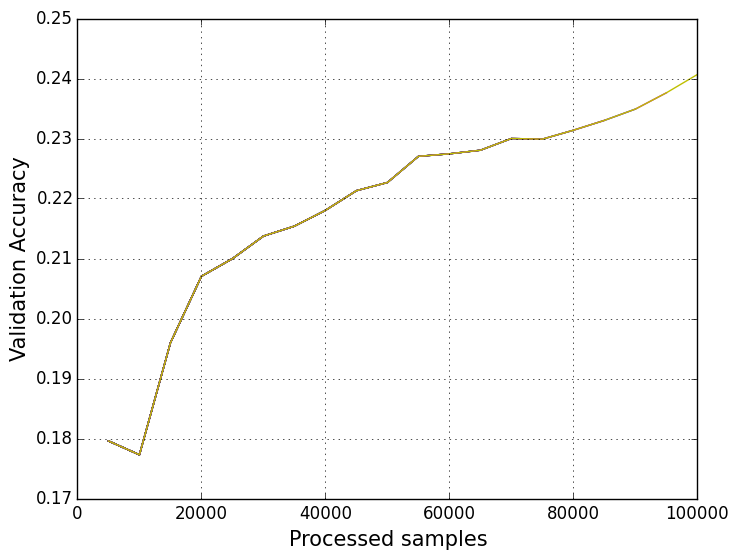

In [9]:
val_interval = 5000
samples_to_process = 3e6
samples_processed = 0

val_samples = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        inputs, input_masks, targets, target_masks, _, _ = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        batch_cost, batch_acc, batch_output = train_func(inputs, targets, input_masks)
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            val_acc, val_output = test_func(Xval, Yval, Xmask_val)
            val_samples += [samples_processed]
            accs += [val_acc]
            plt.plot(val_samples,accs)
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
except KeyboardInterrupt:
    pass


<IPython.core.display.Javascript object>


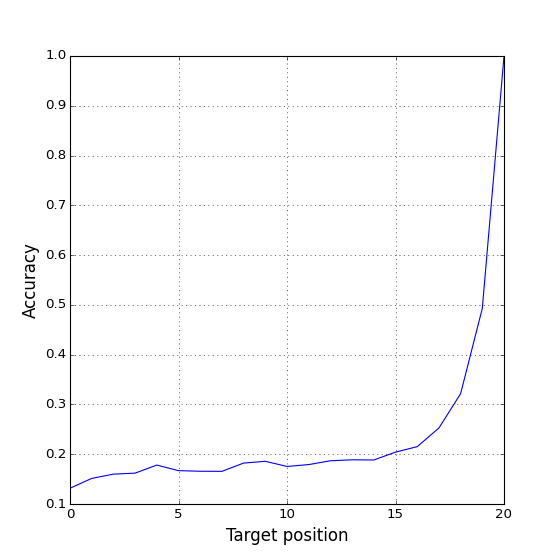

In [10]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(val_output,axis=2)==Yval,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

In [18]:
# plot training cost
#plt.figure(figsize=(7,7))
#plt.plot(costs)
#plt.ylabel('Cost', fontsize=15)
#plt.xlabel('Number of updates', fontsize=15)
#plt.title('Training', fontsize=20)
#plt.show()

#Exercises:
1. Add support for different lengths of targets (hint: add the target_mask to the cost function and only calculate the cost for the non-masked targets)
2. Experiment with changing from GRU to LSTM units. How do this affect the runtime?
3. Make a Decoder with attention (see code below). Try to make a plot of the attention matrix alpha. Can you explain what you see?
**Note: The attention LSTM layer is currentlty not well documented**
4. Implement decaying learning rate (hint Make the learning rate a shared variable and use it as input to the training function. You can call `set_value` and `get_value` on theano shared variables) 
5. Add more layers to Encoder - two layers seems to be working well on many real-life problems
6. Make the Encoder bidirectional (see hints below)
7. Add dropout to the encoder, do you need a seperate function for evaluation now?


####2.  Bidirectional Encoder
In Lasagne bidirectional RNNs are implementated by running a forward model and a backward model separately and then concatenating them before parsing them on to the next layer. You can experiment with using a different merging layer than concat e.g. sum or multiplication see [lasagne merge layers](http://lasagne.readthedocs.org/en/latest/modules/layers/merge.html).

In [ ]:
l_rec_fwd = lasagne.layers.GRULayer(...,backwards=False)
l_rec_bwd = lasagne.layers.GRULayer(...,backwards=True)
l_rec = lasagne.layers.ConcatLayer([l_rec_fwd, l_rec_bwd], axis=2))

####3. Attention Decoder (LSTM)
Interleaved between the layer setup you'll see a lot of print statements and T.grad statements. The T.grad statements where used to track down a disconnected gradient input error. Bascially it tests if theano can take the gradient of the layer..

In [7]:
from decoder_attention import LSTMAttentionDecodeFeedbackLayer

# you can acces the attetion weights alpha by adding l_dec.alpha 
# to the output variables in the theano function

BATCH_SIZE = 100
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
MAX_DIGITS = 20 
MIN_DIGITS = MAX_DIGITS #currently only support for same length outputs - we'll leave it for an exercise to add support for varying length targets
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')


x_sym = T.imatrix()
y_sym = T.imatrix()
xmask_sym = T.matrix()
    

#dummy data to test implementation
#X = np.random.randint(0,10,size=(BATCH_SIZE,15)).astype('int32')
#Xmask = np.ones((BATCH_SIZE,NUM_INPUTS)).astype('float32')

l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
##### ENCODER START #####
l_in = lasagne.layers.InputLayer((None, None))
l_emb = lasagne.layers.EmbeddingLayer(l_in, NUM_INPUTS, NUM_INPUTS, 
                                      W=np.eye(NUM_INPUTS,dtype='float32'),
                                      name='Embedding')
#Here we'll remove the trainable parameters from the embeding layer to constrain 
#it to a simple "one-hot-encoding". You can experiment with removing this line
l_emb.params[l_emb.W].remove('trainable') 
print lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).eval(
    {x_sym: X}).shape
T.grad(lasagne.layers.get_output(l_emb, inputs={l_in: x_sym}).sum(), 
       lasagne.layers.get_all_params(l_emb, trainable=True))




l_mask_enc = lasagne.layers.InputLayer((None, None))
l_enc = lasagne.layers.GRULayer(l_emb, num_units=NUM_UNITS_ENC, name='GRUEncoder', mask_input=l_mask_enc)
print lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_enc, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_enc, trainable=True))
####END OF ENCODER######


####START OF DECODER######
#note that the decoder have its own input layer, we'll use that to plug in the output 
#from the encoder later
l_dec = LSTMAttentionDecodeFeedbackLayer(l_enc,
                                        num_units=NUM_UNITS_DEC, 
                                        aln_num_units=20,
                                        n_decodesteps=MAX_DIGITS+1,
                                        name='LSTMDecoder')
print lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_dec, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_dec, trainable=True))

# We need to do some reshape voodo to connect a softmax layer to the decoder.
# See http://lasagne.readthedocs.org/en/latest/modules/layers/recurrent.html#examples 
l_reshape = lasagne.layers.ReshapeLayer(l_dec, (-1, [2]))
l_softmax = lasagne.layers.DenseLayer(l_reshape, num_units=NUM_OUTPUTS, 
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      name='SoftmaxOutput')
# print lasagne.layers.get_output(l_softmax, x_sym).eval({x_sym: X}).shape
# reshape back to 3d format (here we tied the batch size to the shape of the symbolic variable for X allowing 
#us to use different batch sizes in the model)
l_out = lasagne.layers.ReshapeLayer(l_softmax, (x_sym.shape[0], -1, NUM_OUTPUTS))
print lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, deterministic=False).eval(
    {x_sym: X, xmask_sym: Xmask}).shape
T.grad(lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}).sum(), 
       lasagne.layers.get_all_params(l_dec, trainable=True))

print ""
###END OF DECODER######



(100, 20, 27)
(100, 20, 10)
(100, 21, 10)
(100, 21, 11)



In [8]:
#get output of encoder using X and Xmask as input
output_decoder_train = lasagne.layers.get_output(l_out, inputs={l_in: x_sym, l_mask_enc: xmask_sym}, 
                                                 deterministic=False)

#cost function
total_cost = T.nnet.categorical_crossentropy(
    T.reshape(output_decoder_train, (-1, NUM_OUTPUTS)), y_sym.flatten())
mean_cost = T.mean(total_cost)
#accuracy function
acc = T.mean(T.eq(T.argmax(output_decoder_train,axis=-1),y_sym))

#Get parameters of both encoder and decoder
all_parameters = lasagne.layers.get_all_params(l_out, trainable=True)

print "Trainable Model Parameters"
print "-"*40
for param in all_parameters:
    print param, param.get_value().shape
print "-"*40

#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(mean_cost, all_parameters)]
all_grads = lasagne.updates.total_norm_constraint(all_grads,3)

#Compile Theano functions
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)
train_func = theano.function([x_sym, y_sym, xmask_sym], [mean_cost, acc, output_decoder_train], updates=updates)
#since we don't have any stochasticity in the network we will just use the training graph without any updates given
test_func = theano.function([x_sym, y_sym, xmask_sym], [acc, output_decoder_train, l_dec.alpha])


/Users/sorensonderby/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/pfunc.py:133: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  strict=rebuild_strict)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/function_module.py:147: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  fgraph = gof.fg.FunctionGraph(orig_inputs, orig_outputs)
/Users/sorensonderby/Documents/phd/RNN/Theano/theano/compile/function_module.py:1212: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,wa

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (27, 10)
GRUEncoder.W_hid_to_updategate (10, 10)
GRUEncoder.b_updategate (10,)
GRUEncoder.W_in_to_resetgate (27, 10)
GRUEncoder.W_hid_to_resetgate (10, 10)
GRUEncoder.b_resetgate (10,)
GRUEncoder.W_in_to_hidden_update (27, 10)
GRUEncoder.W_hid_to_hidden_update (10, 10)
GRUEncoder.b_hidden_update (10,)
GRUEncoder.hid_init (1, 10)
LSTMDecoder.W_hid_to_ingate (10, 10)
LSTMDecoder.b_ingate (10,)
LSTMDecoder.W_hid_to_forgetgate (10, 10)
LSTMDecoder.b_forgetgate (10,)
LSTMDecoder.W_hid_to_cell (10, 10)
LSTMDecoder.b_cell (10,)
LSTMDecoder.W_hid_to_outgate (10, 10)
LSTMDecoder.b_outgate (10,)
LSTMDecoder.W_weightedhid_to_ingate (10, 10)
LSTMDecoder.W_weightedhid_to_forgetgate (10, 10)
LSTMDecoder.W_weightedhid_to_cell (10, 10)
LSTMDecoder.W_weightedhid_to_outgate (10, 10)
LSTMDecoder.W_cell_to_ingate (10,)
LSTMDecoder.W_cell_to_forgetgate (10,)
LSTMDecoder.W_cell_to_outgate (10,)
LSTMDecoder.Alig

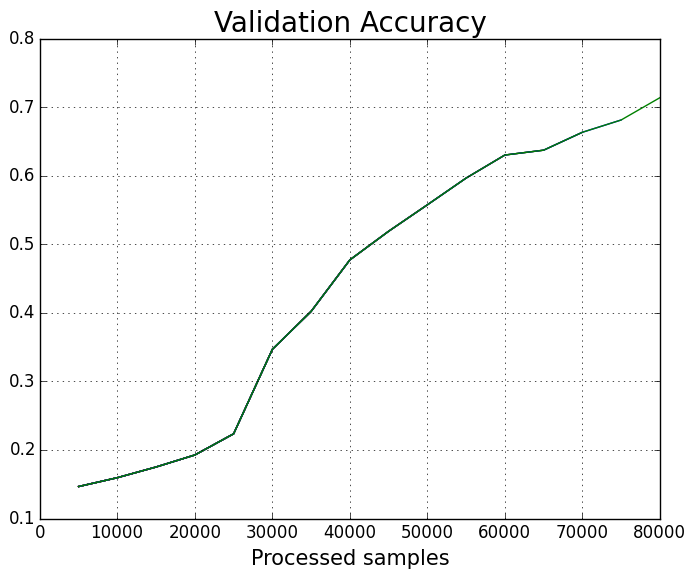

In [9]:
val_interval = 5000
samples_to_process = 1.5e5
samples_processed = 0
val_samples = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        inputs, input_masks, targets, target_masks, _, _ = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        batch_cost, batch_acc, batch_output = train_func(inputs, targets, input_masks)
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #print i, samples_processed
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            val_acc, val_output, alpha = test_func(Xval, Yval, Xmask_val)
            val_samples += [samples_processed]
            accs += [val_acc]
            plt.plot(val_samples,accs)
            plt.ylabel('', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('Validation Accuracy', fontsize=20)
            plt.grid('on')
            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.show()
except KeyboardInterrupt:
    pass
        

<IPython.core.display.Javascript object>


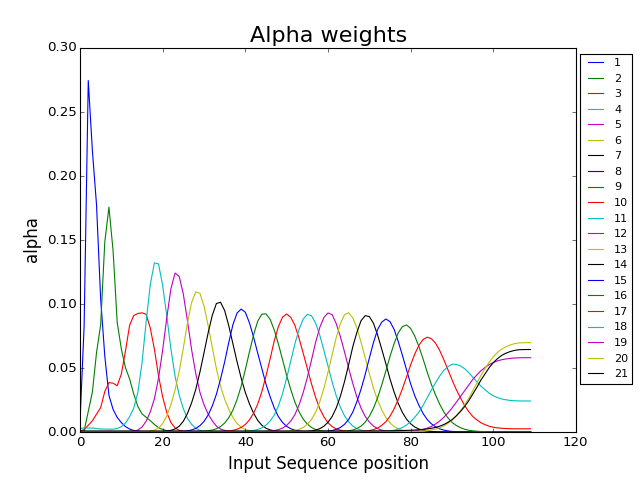

/Users/sorensonderby/anaconda/lib/python2.7/site-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "outside". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


In [10]:
#Plot of average attention weight as a function of the sequence position for each of 
#the 21 targets in the output sequence i.e. each line is the mean postion of the 
#attention for each target position.

np.mean(alpha,axis=0).shape
plt.figure()
plt.plot(np.mean(alpha,axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,22)), loc='outside', bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()
